In [98]:
import numpy as np
import pandas as pd
from functions import preprocess, activations, losses

In [99]:
df = pd.read_csv('datasets/Train.csv')
df = df.dropna(axis=1).drop(['ID','country','population'],axis=1)
df2 = preprocess.min_max(df)
df2 = df2.iloc[:100000,:]

In [100]:
features, target = df2.loc[:,'Q1':'Q25'], df2['target']

X, Y = features.values.T, target.values
x_train, y_train, x_test, y_test = preprocess.split(X, Y)

# Multi-layered Model
<img src='images/net.png' width='500px'>

# Modelling

In [101]:
def initiate_model(X, Y, learning_rate=0.001, hidden_layers=[10,10]):
    
    n_features = X.shape[0]
    layers = [n_features, *hidden_layers, 1]
    n_layers = len(layers)
    
    model = {
        'learning_rate':learning_rate, 
        'layers':layers, 
        'Y':Y, 
        'loss':0,
         'W':{}, 'B':{}, 'Z':{}, 'A':{0:X},
        'dW':{},'dB':{},'dZ':{},'dA':{},
        }

    for layer in range(1, n_layers):
        #HE initialization
        model['W'][layer] = np.random.randn(layers[layer], layers[layer-1]) / np.sqrt(layers[layer-1])
        model['B'][layer] = np.zeros((layers[layer], 1))
                       
    return model

In [102]:
def forward_1_layer(W, A_min, B, act=activations.sigmoid):
    
    Z = W.dot(A_min) + B 
    A = act(Z)
    
    return Z, A

def forwarding(model):

    for i in range(1, n_layers):
        
        model['Z'][i], model['A'][i] = forward_1_layer(
            W =     model['W'][i], 
            A_min = model['A'][i-1], 
            B =     model['B'][i], 
            act =   activations.sigmoid)
     
    model['loss'] = losses.binary_crossentropy(model['A'][final_layer_index], model['Y'])
        
    return model

In [103]:
def backward_1_layer(W, A, dA, B, A_min, Z, learning_rate, actd=activations.dRelu):
    
    dZ = dA * Z
    dA_min = np.dot(W.T, dZ)
    dW = 1 / A_min.shape[1] * np.dot(dZ, A_min.T)
    dB = 1 / A_min.shape[1] * np.dot(dZ, np.ones([dZ.shape[1], 1]))
    
    W = W - learning_rate * dW
    B = B - learning_rate * dB

    return dA_min, W, B


def backwarding(model):

    y_real = model['Y']
    y_pred = model['A'][final_layer_index]
    extra = 10e-5 #Against zero division
    
    model['dA'][final_layer_index] = (-y_real / (y_pred + extra)) - ((1-y_real)/(1-y_pred + extra))

    for i in range(n_layers -1, 0, -1):

        model['dA'][i-1], model['W'][i], model['B'][i] = backward_1_layer(
            W = model['W'][i],
            A = model['A'][i],
            dA = model['dA'][i],
            B = model['B'][i],
            A_min = model['A'][i-1],
            Z = model['Z'][i],
            learning_rate=0.001
            )
        
    return model

In [106]:
model = initiate_model(x_train, y_train)
logger = []

n_layers = len(model['layers'])
final_layer_index = n_layers - 1

for i in range(10000):
    
    model = forwarding(model)
    
    if (i%100==0):
        print(model['loss']) 
    
    logger.append(model['loss'])    
    model = backwarding(model)

11.464756091803864
11.438494884255654
11.385850657101635
11.280267299395904
11.067048493586157
10.616976221640197


<ipython-input-103-c4a0e6269d28>:3: RuntimeWarning: overflow encountered in multiply
  dZ = dA * Z


nan


KeyboardInterrupt: 

<AxesSubplot:>

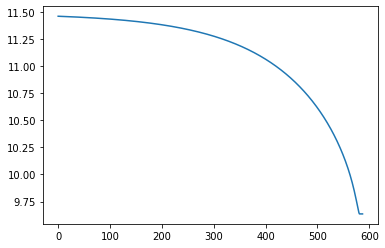

In [107]:
pd.Series(logger).plot()